# Anomaly Detection

In this notebook we try to detect whether a dataset contains anomalies or not. <br>
We have a time series dataset, that contains the temperature of a device through time.

### Looking at the data

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
data = pd.read_csv('Temperature.csv')

In [3]:
data.head()

,timestamp,value
0,7/4/2013 0:00,69.880835
1,7/4/2013 1:00,71.220227
2,7/4/2013 2:00,70.877805
3,7/4/2013 3:00,68.959400
4,7/4/2013 4:00,69.283551


In [4]:
data.shape

(7267, 2)

In [5]:
data.columns

Index(['timestamp', 'value'], dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


We need to make the timestamp column into datetime

In [7]:
data.timestamp = pd.to_datetime(data.timestamp)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7267 non-null   datetime64[ns]
 1   value      7267 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 113.7 KB


In [9]:
data.describe()

,timestamp,value
count,7267,7267.000000
mean,2013-12-17 01:43:01.477914112,71.242433
min,2013-07-04 00:00:00,57.458406
25%,2013-10-01 13:30:00,68.369411
50%,2013-12-19 04:00:00,71.858493
75%,2014-03-06 01:30:00,74.430958
max,2014-05-28 15:00:00,86.223213
std,NaN,4.247509


### Visualizing the data

In [10]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.graph_objs as go

app = dash.Dash(__name__)

app.layout = html.Div(style={'backgroundColor': '#111111', 'color': '#7FDBFF'}, children=[
    html.H1(style={'textAlign': 'center'}),

    dcc.Graph(
        id='example-graph',
        figure={
            'data': [
                go.Scatter(
                    x=data.timestamp,
                    y=data.value,
                    mode='lines+markers',
                    name='temperatures',
                    line=dict(color='#FF851B', width=1)
                ),
            ],
            'layout': go.Layout(
                titlefont=dict(color='#7FDBFF', size=20),
                xaxis=dict(title='Date', tickangle=-45, tickformat='%Y-%m-%d', color='#7FDBFF'),
                yaxis=dict(title='Temperature', color='#7FDBFF'),
                plot_bgcolor='#111111',
                paper_bgcolor='#111111',
                font=dict(color='#7FDBFF'),
                hovermode='closest'
            )
        }
    )
])

if __name__ == '__main__':
    app.run_server(mode='inline')

### Feature Engineering

In [11]:
def categorize_datetime(dt):
    hour = dt.hour
    if dt.weekday() < 5:
        if 7 <= hour < 19:
            return 'Weekday Day'
        else:
            return 'Weekday Night'
    else:
        if 7 <= hour < 19:
            return 'Weekend Day'
        else:
            return 'Weekend Night'

df = data.copy()
df['dtcat'] = df.timestamp.apply(categorize_datetime)

df.head()

,timestamp,value,dtcat
0,2013-07-04 00:00:00,69.880835,Weekday Night
1,2013-07-04 01:00:00,71.220227,Weekday Night
2,2013-07-04 02:00:00,70.877805,Weekday Night
3,2013-07-04 03:00:00,68.959400,Weekday Night
4,2013-07-04 04:00:00,69.283551,Weekday Night


In [12]:
df.dtcat.value_counts()

dtcat
Weekday Day      2622
Weekday Night    2621
Weekend Night    1016
Weekend Day      1008
Name: count, dtype: int64

In [13]:
df['month'] = df.timestamp.dt.month
df['day'] = df.timestamp.dt.day
df['hour'] = df.timestamp.dt.hour
df['weekday'] = df.timestamp.dt.weekday

In [14]:
df.head()

,timestamp,value,dtcat,month,day,hour,weekday
0,2013-07-04 00:00:00,69.880835,Weekday Night,7,4,0,3
1,2013-07-04 01:00:00,71.220227,Weekday Night,7,4,1,3
2,2013-07-04 02:00:00,70.877805,Weekday Night,7,4,2,3
3,2013-07-04 03:00:00,68.959400,Weekday Night,7,4,3,3
4,2013-07-04 04:00:00,69.283551,Weekday Night,7,4,4,3


##### Now we can drop the timestamp column

In [15]:
df.drop('timestamp', axis=1, inplace=True)
df.head()

,value,dtcat,month,day,hour,weekday
0,69.880835,Weekday Night,7,4,0,3
1,71.220227,Weekday Night,7,4,1,3
2,70.877805,Weekday Night,7,4,2,3
3,68.959400,Weekday Night,7,4,3,3
4,69.283551,Weekday Night,7,4,4,3


##### Visualizing the temperature values for each feature

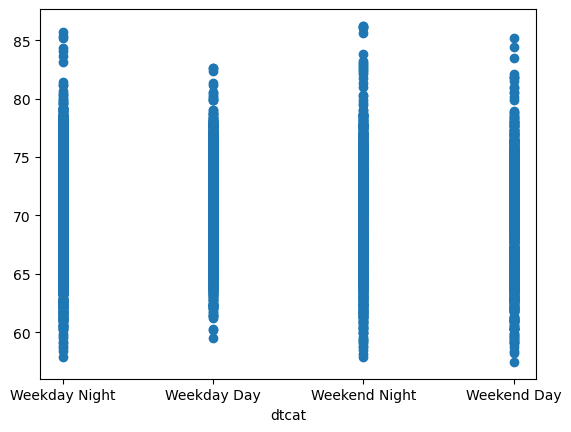

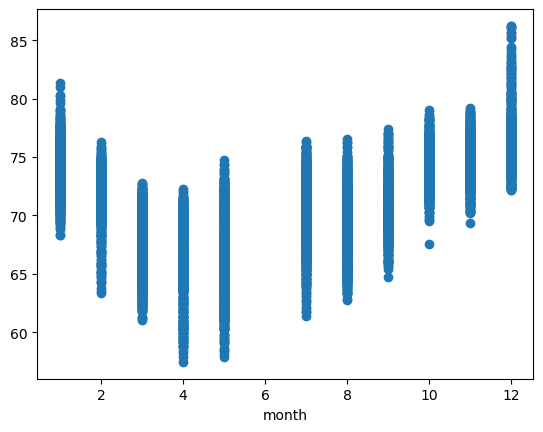

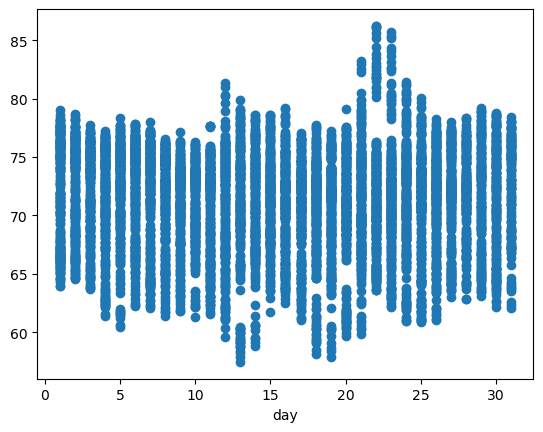

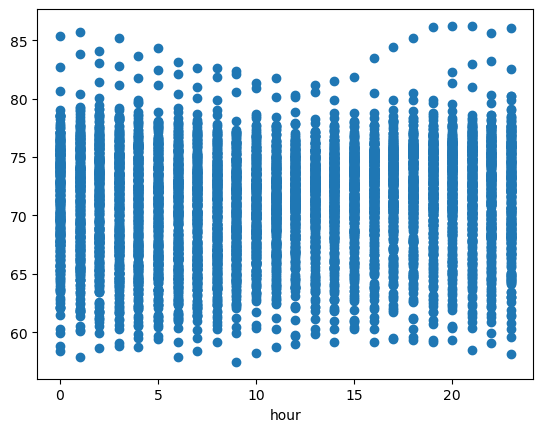

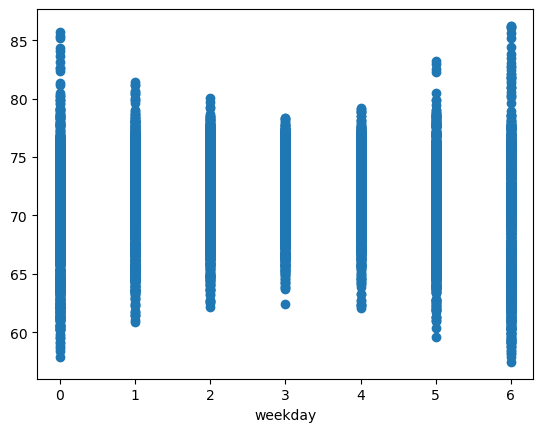

In [16]:
for col in df.drop('value', axis=1):
    plt.scatter(df[col], df.value)
    plt.xlabel(f'{col}')
    plt.show()

### K-Means

#### Pre-processing the data

Let's perform clustering on our dataset. <br>
First we need to make sure the data is in the right format.

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [18]:
encoder = OrdinalEncoder()
df.dtcat = encoder.fit_transform(df.loc[:, ['dtcat']])

In [19]:
df.head()

,value,dtcat,month,day,hour,weekday
0,69.880835,1.0,7,4,0,3
1,71.220227,1.0,7,4,1,3
2,70.877805,1.0,7,4,2,3
3,68.959400,1.0,7,4,3,3
4,69.283551,1.0,7,4,4,3


In [20]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [21]:
df_scaled.head()

,value,dtcat,month,day,hour,weekday
0,-0.320586,-0.055989,0.124589,-1.369251,-1.661537,0.005769
1,-0.005228,-0.055989,0.124589,-1.369251,-1.517172,0.005769
2,-0.085851,-0.055989,0.124589,-1.369251,-1.372807,0.005769
3,-0.537536,-0.055989,0.124589,-1.369251,-1.228442,0.005769
4,-0.461215,-0.055989,0.124589,-1.369251,-1.084077,0.005769


#### Finding the best value of K

We will find an optimal value of K by checking the silhoutte scores

In [22]:
silhouette_scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(df_scaled)
    
    silhouette_avg = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

Let's plot the silhoutte scores of each value of the number of clusters. <br>
This visual representation will make the task easier

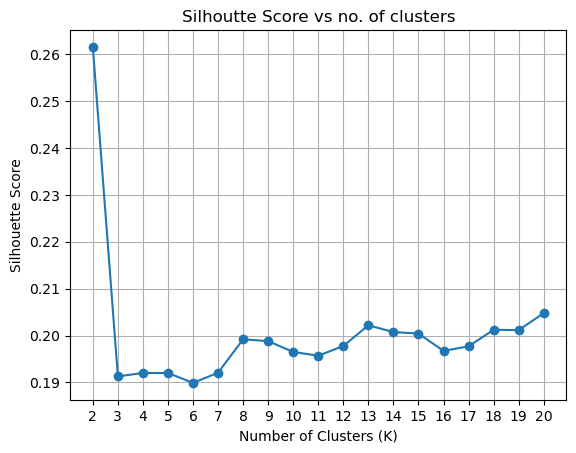

In [23]:
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.title('Silhoutte Score vs no. of clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.xticks(range(2, 21))
plt.show()

It seems that the best value of K is 2. <br>
Let's use this knowledge to cluster our data.

In [24]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
df['cluster'] = kmeans.fit_predict(df_scaled)
df.cluster

0       0
1       0
2       0
3       0
4       0
       ..
7262    0
7263    0
7264    0
7265    0
7266    0
Name: cluster, Length: 7267, dtype: int32

In [25]:
df.cluster.value_counts()

cluster
0    5229
1    2038
Name: count, dtype: int64

Let's see how the algorithm has clustered our data.

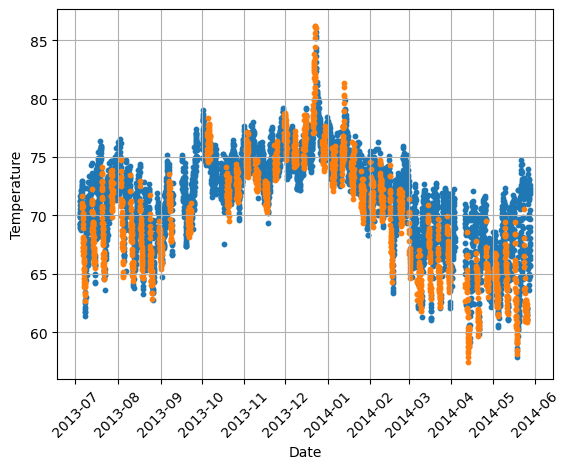

In [26]:
plt.xlabel('Date')
plt.grid(True)
plt.ylabel('Temperature')
plt.xticks(rotation=45);
for cluster_label in range(2):
    cluster_data = data.loc[df.cluster[df.cluster == cluster_label].index]
    plt.scatter(cluster_data.timestamp, cluster_data.value, label=f'Cluster {cluster_label}', s=10)

How about for each individual feature?

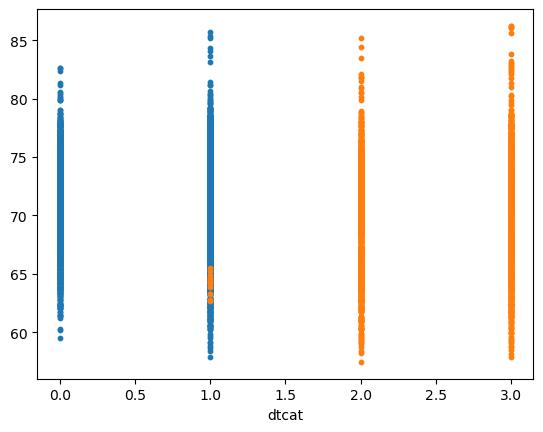

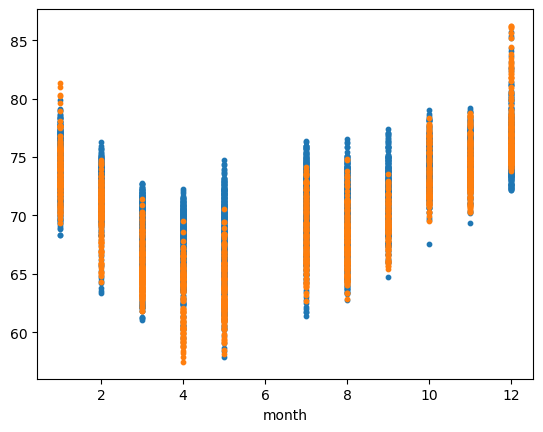

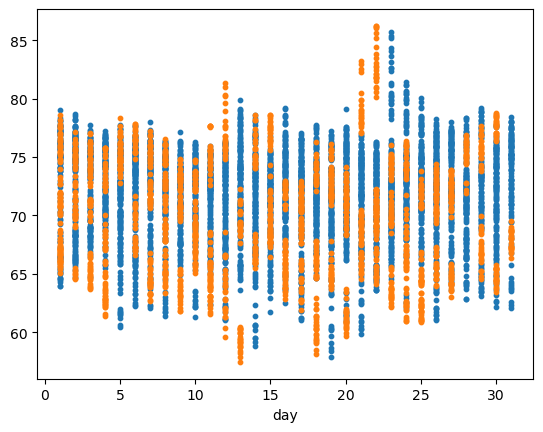

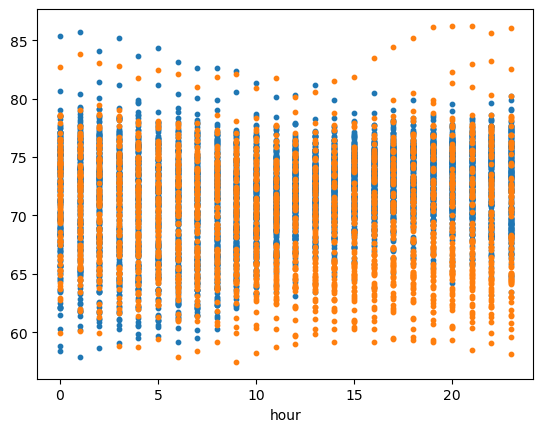

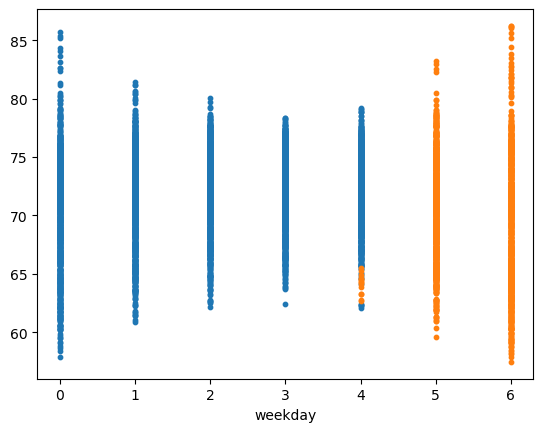

In [27]:
for col in df.drop(['value', 'cluster'], axis=1):
    for cluster_label in range(2):
        cluster_data = df.loc[df.cluster[df.cluster == cluster_label].index]
        plt.scatter(cluster_data[col], cluster_data.value, label=f'Cluster {cluster_label}', s=10)
    plt.xlabel(f'{col}')
    plt.show()

The algorithm has clustered our high dimentional data, however it is hard for us to understand this because we humans can not perceive high dimentions. <br>
Thats where dimentionality reduction comes in

### Applying PCA to derive 2 Principle Components 

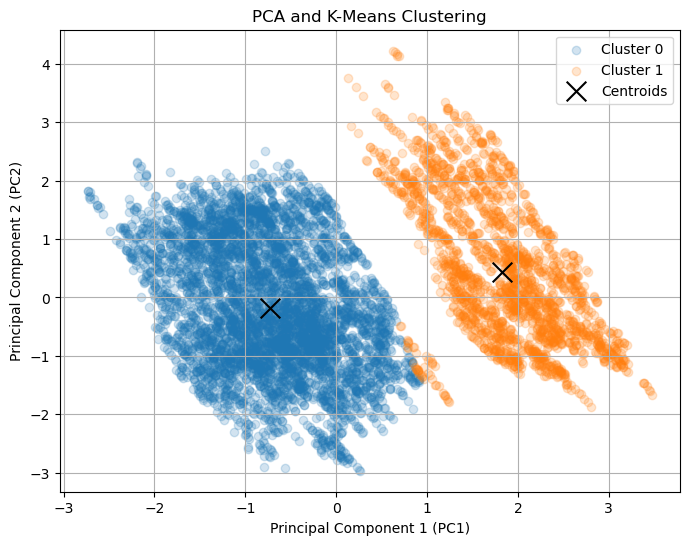

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
df_pca['cluster'] = kmeans.fit_predict(df_pca)

plt.figure(figsize=(8, 6))
for cluster in range(2):
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.2)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='x', s=200, color='black', label='Centroids')

plt.title('PCA and K-Means Clustering')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.grid(True)
plt.show()

It's pretty clear that there are two clusters once we reduce our data down to two principle components

In [29]:
print(f"silhoutte score: {silhouette_score(df_pca, kmeans.labels_)}")

silhoutte score: 0.5037315928068052


We also see a drastic increase in the silhoutte score on the dimensionally reduced data

# Detecting Anomalies

#### It's time to detect anomalies in our dataset.

## EllipticEnvelope (with contamination = 0.01)

We will be using the EllipticEnvelope algortihm to detect anomalies in our data. <br>
We will use the default contamination value first, which is 0.01 (1% of the data)

In [30]:
from sklearn.covariance import EllipticEnvelope

cov1 = EllipticEnvelope(contamination=0.01)
cov1.fit(df_pca.drop(columns='cluster'))

EllipticEnvelope(contamination=0.01)

In [31]:
outliers = cov1.predict(df_pca.drop(columns='cluster'))
anomalies = df_pca[outliers == -1]

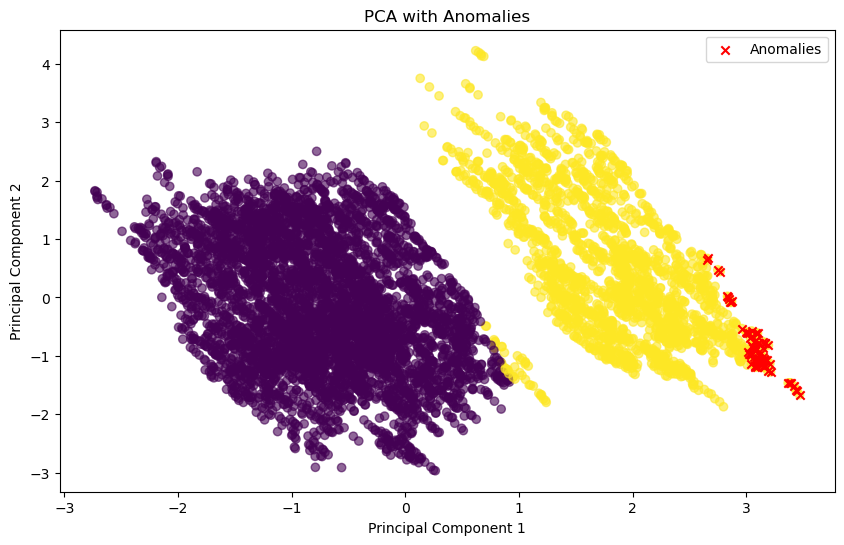

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=df_pca['cluster'], alpha=0.6)
plt.scatter(anomalies.iloc[:, 0], anomalies.iloc[:, 1], color='red', marker='x', label='Anomalies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with Anomalies')
plt.legend()
plt.show()

In [33]:
anomalies

,PC1,PC2,cluster
72,2.835938,0.021421,1
73,2.840892,0.001700,1
74,2.871896,-0.068360,1
75,2.845159,-0.026840,1
77,2.864958,-0.085394,1
...,...,...,...
7181,3.138124,-1.137402,1
7182,3.134004,-1.139586,1
7183,3.039347,-0.966814,1
7184,3.042248,-0.982568,1


Let's try to visualize the anomalies in each feature

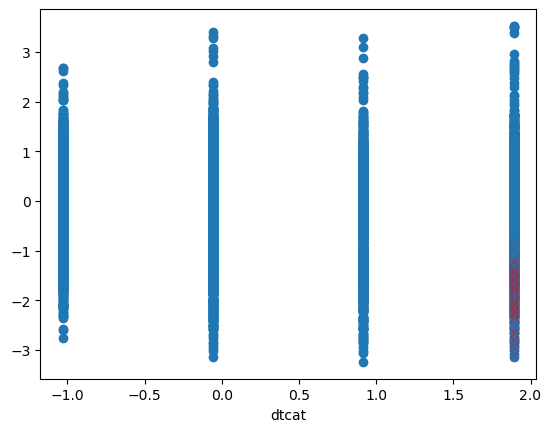

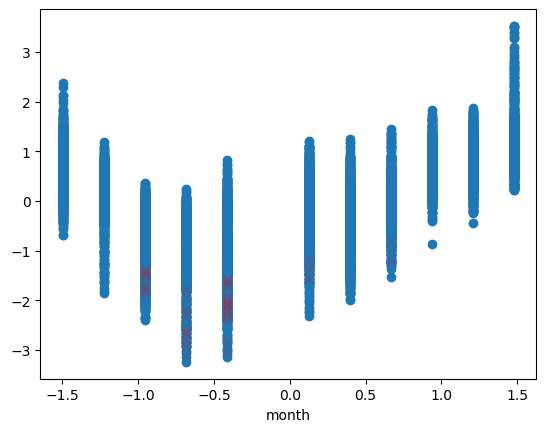

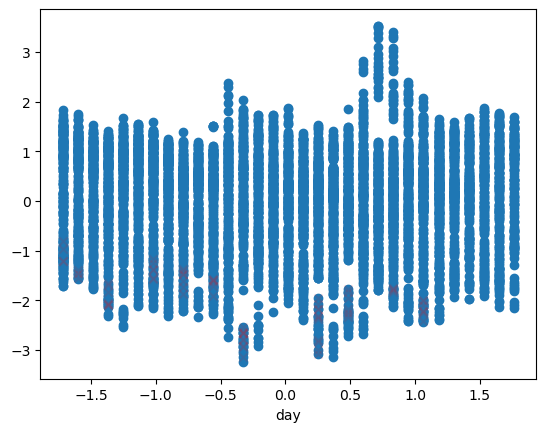

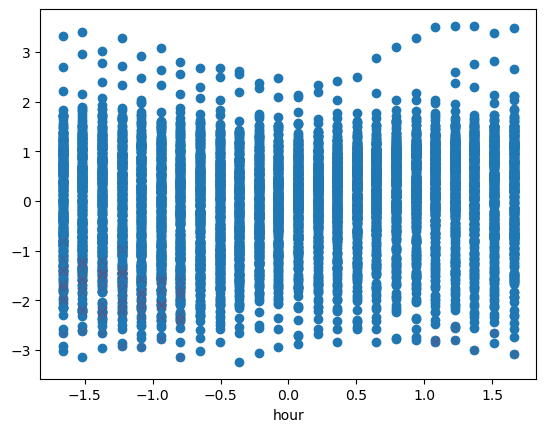

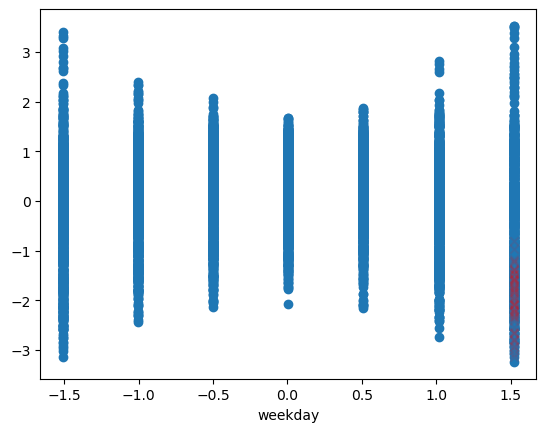

In [34]:
anomalies_original = df_scaled[outliers == -1]
for col in df_scaled.drop('value', axis=1):
    plt.scatter(df_scaled[col], df_scaled.value)
    plt.scatter(anomalies_original[col], anomalies_original.value, color='red', marker='x', label='Anomalies', alpha=0.1)
    plt.xlabel(f'{col}')
    plt.show()

##### Visualizing the anomalies on our origional data

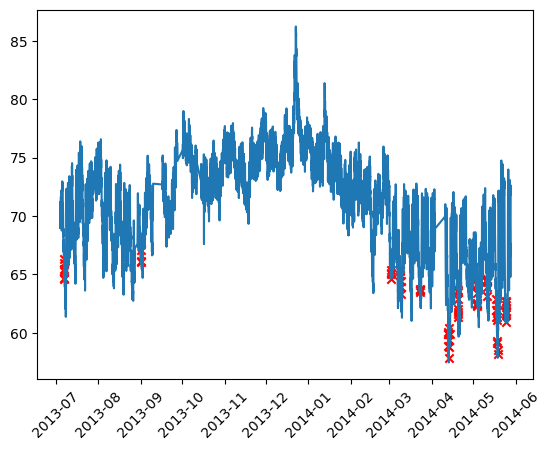

In [35]:
plt.plot(data.timestamp, data.value)
plt.scatter(data.loc[anomalies.index].timestamp, data.loc[anomalies.index].value, color='red', marker='x')
plt.xticks(rotation=45);

## EllipticEnvelope (with contamination = 1.5 x IQR)

Let's use the IQR method to find the number of outliers in our data, and use that as the contamination value

In [36]:
Q1 = df_pca.quantile(0.25)
Q3 = df_pca.quantile(0.75)
IQR = Q3 - Q1

outlier_bound = 1.5 * IQR

num_outliers = ((df_pca < (Q1 - outlier_bound)) | (df_pca > (Q3 + outlier_bound))).sum().max()

total_points = df_pca.shape[0]

contamination_fraction = num_outliers / total_points

print(f'records: {df_pca.shape[0]}')
print(f'outliers: {num_outliers}')
print(f'contamination factor: {contamination_fraction}')

records: 7267
outliers: 10
contamination factor: 0.001376083665886886


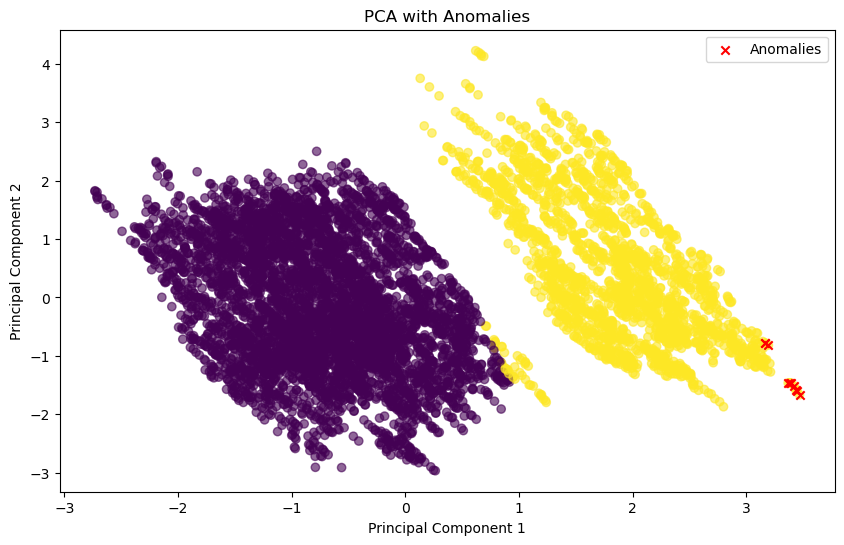

In [37]:
from sklearn.covariance import EllipticEnvelope

cov = EllipticEnvelope(contamination=contamination_fraction)

cov.fit(df_pca.drop(columns='cluster'))

outliers = cov.predict(df_pca.drop(columns='cluster'))

anomalies = df_pca[outliers == -1]

plt.figure(figsize=(10, 6))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=df_pca['cluster'], cmap='viridis', alpha=0.6)
plt.scatter(anomalies.iloc[:, 0], anomalies.iloc[:, 1], color='red', marker='x', label='Anomalies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with Anomalies')
plt.legend()
plt.show()

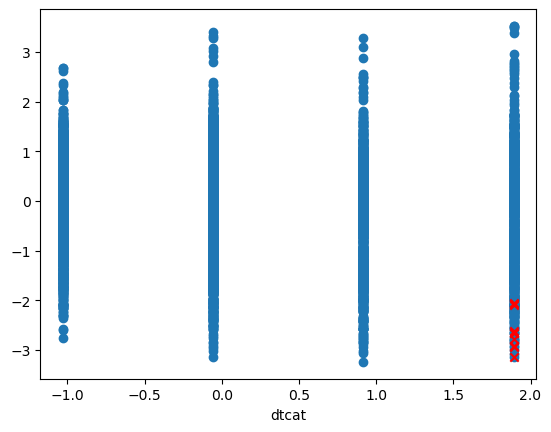

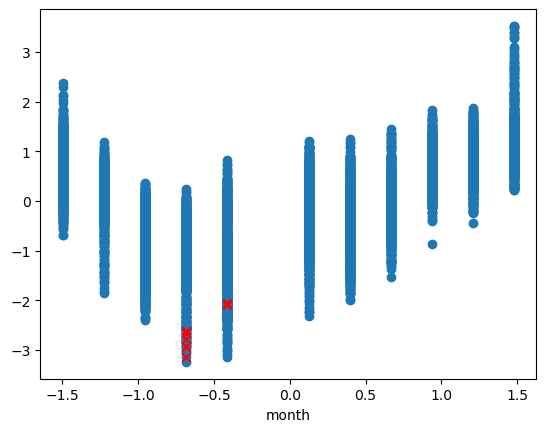

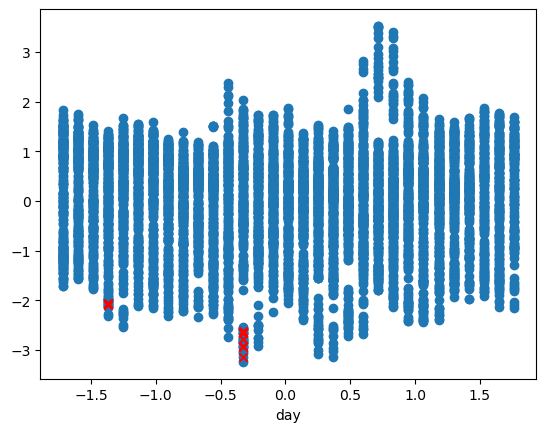

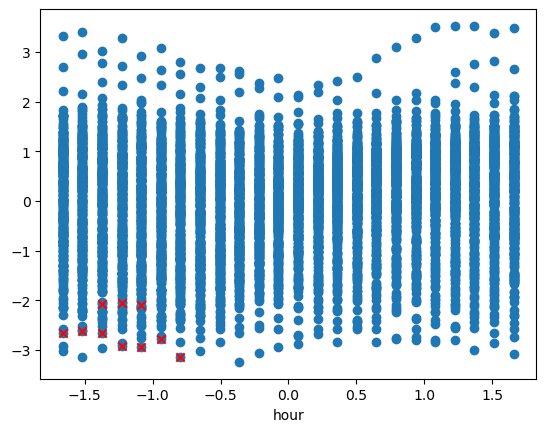

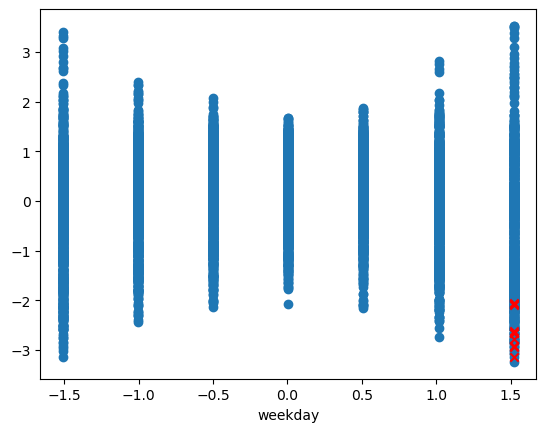

In [38]:
anomalies_original = df_scaled[outliers == -1]
for col in df_scaled.drop('value', axis=1):
    plt.scatter(df_scaled[col], df_scaled.value)
    plt.scatter(anomalies_original[col], anomalies_original.value, color='red', marker='x', label='Anomalies')
    plt.xlabel(f'{col}')
    plt.show()

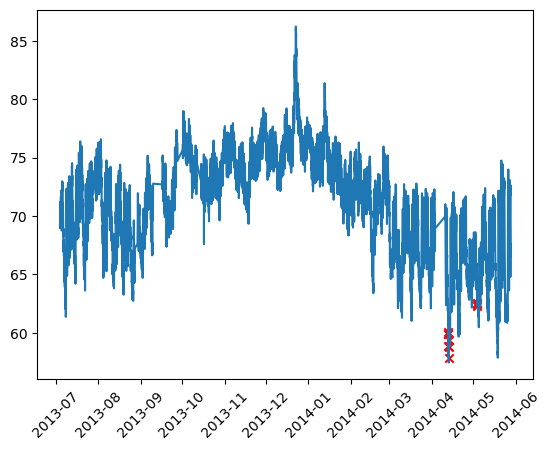

In [39]:
plt.plot(data.timestamp, data.value)
plt.scatter(data.loc[anomalies.index].timestamp, data.loc[anomalies.index].value, color='red', marker='x')
plt.xticks(rotation=45);

## Isolation Forest (with contamination = 1.5 x IQR)

#### Let's use the Isolation Forest algorithm to detect anomalies

In [40]:
Q1 = df_pca.quantile(0.25)
Q3 = df_pca.quantile(0.75)
IQR = Q3 - Q1

outlier_bound = 1.5 * IQR
num_outliers = ((df_pca < (Q1 - outlier_bound)) | (df_pca > (Q3 + outlier_bound))).sum().max()
total_points = df_pca.shape[0]
contamination_fraction = num_outliers / total_points

print(f'records: {df_pca.shape[0]}')
print(f'outliers: {num_outliers}')
print(f'contamination factor: {contamination_fraction}')

records: 7267
outliers: 10
contamination factor: 0.001376083665886886


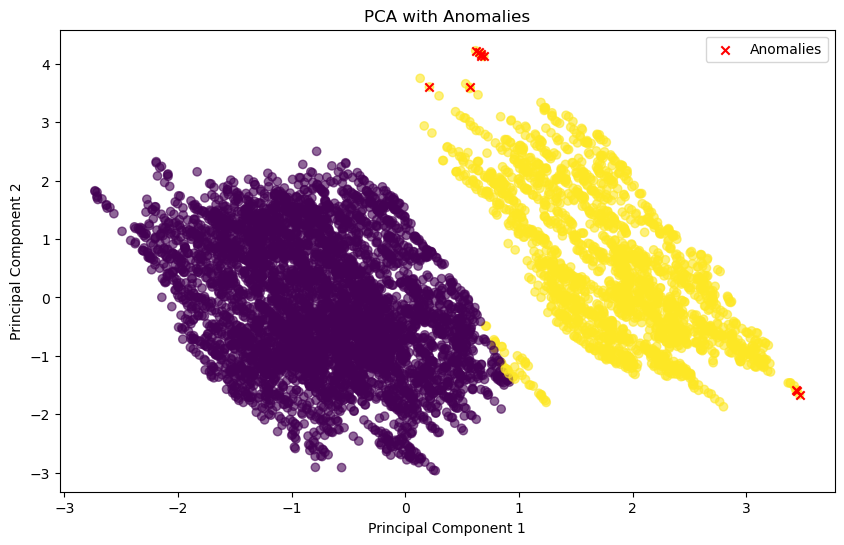

In [41]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=contamination_fraction, random_state=1)
clf.fit(df_pca.drop(columns='cluster'))

outliers = clf.predict(df_pca.drop(columns='cluster'))
anomalies = df_pca[outliers == -1]

plt.figure(figsize=(10, 6))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=df_pca['cluster'], cmap='viridis', alpha=0.6)
plt.scatter(anomalies.iloc[:, 0], anomalies.iloc[:, 1], color='red', marker='x', label='Anomalies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with Anomalies')
plt.legend()
plt.show()

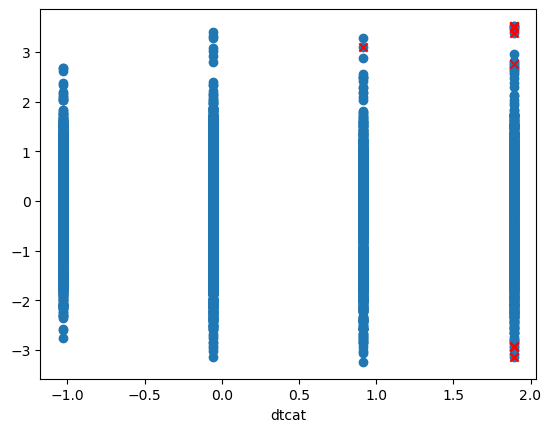

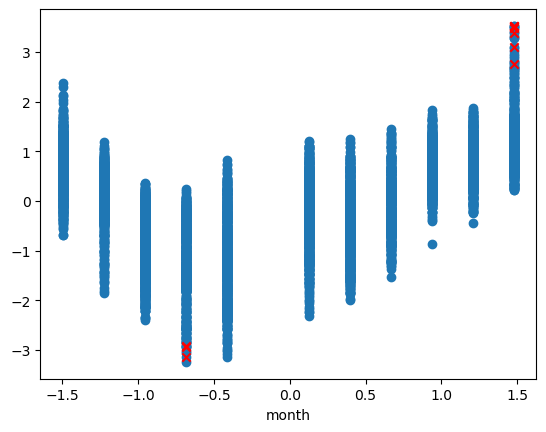

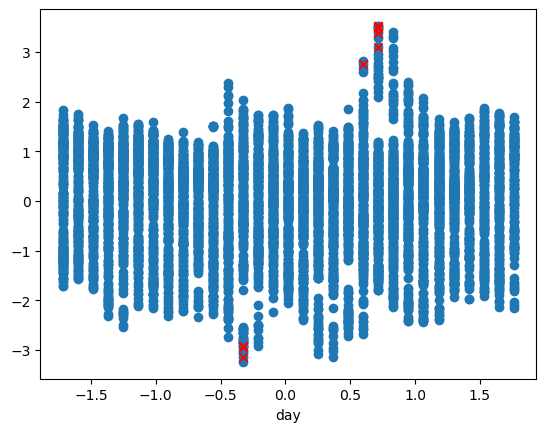

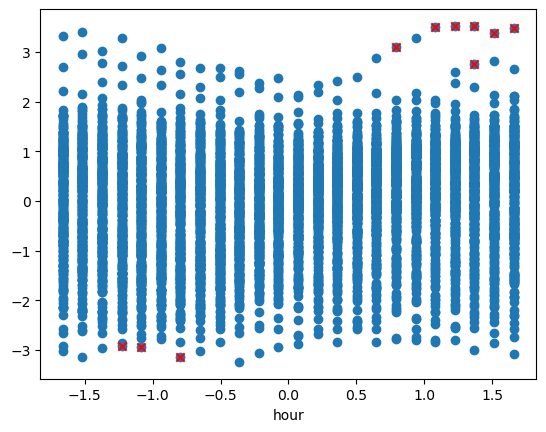

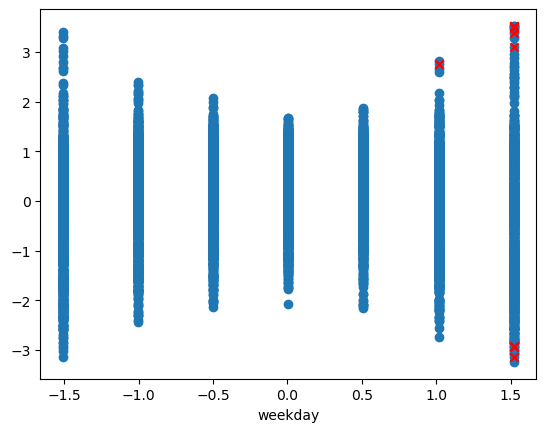

In [42]:
anomalies_original = df_scaled[outliers == -1]
for col in df_scaled.drop('value', axis=1):
    plt.scatter(df_scaled[col], df_scaled.value)
    plt.scatter(anomalies_original[col], anomalies_original.value, color='red', marker='x', label='Anomalies')
    plt.xlabel(f'{col}')
    plt.show()

In [43]:
app = dash.Dash(__name__)

app.layout = html.Div(style={'backgroundColor': '#111111', 'color': '#7FDBFF'}, children=[
    html.H1(style={'textAlign': 'center'}),

    dcc.Graph(
        id='example-graph',
        figure={
            'data': [
                go.Scatter(
                    x=data.timestamp,
                    y=data.value,
                    mode='lines+markers',
                    name='temperatures',
                    line=dict(color='#FF851B', width=1)
                ),
                go.Scatter(
                    x=data.loc[anomalies.index].timestamp,
                    y=data.loc[anomalies.index].value,
                    mode='markers',
                    name='anamolies',
                    marker=dict(symbol='x', color='red', size=10)
                )
            ],
            'layout': go.Layout(
                titlefont=dict(color='#7FDBFF', size=20),
                xaxis=dict(title='Date', tickangle=-45, tickformat='%Y-%m-%d', color='#7FDBFF'),
                yaxis=dict(title='Temperature', color='#7FDBFF'),
                plot_bgcolor='#111111',
                paper_bgcolor='#111111',
                font=dict(color='#7FDBFF'),
                hovermode='closest'
            )
        }
    )
])

if __name__ == '__main__':
    app.run_server(mode='inline')

### In this notebook we identifying potential outliers in our dataset. Feature engineering, and reducing the dimensions of our data, along with visualizing these anomalies also provided valuabe insights into our data and highlighted areas warranting further investigation